# Prepare data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Load data
train_df = pd.read_csv("../sales_train.csv.gz")
test_df  = pd.read_csv("../test.csv.gz")

categories = pd.read_csv('../item_categories.csv')
items = pd.read_csv('../items.csv')
shops = pd.read_csv('../shops.csv')

In [2]:
%store -r __prepare_data_4

In [3]:
%%time
__prepare_data_4

CPU times: user 2min 58s, sys: 1min 55s, total: 4min 53s
Wall time: 5min 9s


In [4]:
train33 = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<34)].fillna(0)

X_train33 = train33[train33.date_block_num <  33][predictors]
X_valid33 = train33[train33.date_block_num == 33][predictors]
y_train33 = train33[train33.date_block_num <  33].target
y_valid33 = train33[train33.date_block_num == 33].target

In [5]:
%%time
from sklearn.ensemble import RandomForestRegressor
base_model33 = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6) #len(predictors)/2
base_model33.fit(X_train33, y_train33)

CPU times: user 1h 8min 6s, sys: 44.8 s, total: 1h 8min 51s
Wall time: 18min 44s


In [6]:
train32 = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<33)].fillna(0)

X_train32 = train32[train32.date_block_num <  32][predictors]
X_valid32 = train32[train32.date_block_num == 32][predictors]
y_train32 = train32[train32.date_block_num <  32].target
y_valid32 = train32[train32.date_block_num == 32].target

In [7]:
%%time
base_model32 = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6) #len(predictors)/2
base_model32.fit(X_train32, y_train32)

CPU times: user 1h 6min 42s, sys: 49.2 s, total: 1h 7min 31s
Wall time: 18min 59s


In [8]:
from sklearn.metrics import mean_squared_error

ypred = base_model33.predict(X_valid33)
rmse = np.sqrt(mean_squared_error(y_valid33, ypred))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred)))

RMSE good: 1.046088
Average good: 0.3248986682943419


In [9]:
ypred = base_model32.predict(X_valid32)
rmse = np.sqrt(mean_squared_error(y_valid32, ypred))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred)))

RMSE good: 0.904009
Average good: 0.31928851958564863


In [10]:
ypred = base_model32.predict(X_valid33)
rmse = np.sqrt(mean_squared_error(y_valid33, ypred))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred)))

RMSE good: 0.946987
Average good: 0.3233222077952068


Interesting: taking date #33 out of training makes model superior. What is wrong with date #33? Let's filter out crap.

In [4]:
# based on tables from 2019.11.16/trends_combined.ipynb I choose those shops to be taken out:
closed_shops = [0, 1, 8, 9, 11, 13, 17, 20, 23,  27,  29, 30, 32, 33,  36,  40, 43, 54]

# one of those, though, needs to be predicted (#36):
print(test_df[test_df.shop_id.isin(closed_shops)].shop_id.unique())

# and one of those (#51) does not:
print(set(all_data.shop_id.unique()).difference(test_df.shop_id.unique()))

# this explains why shop #36 is not a good shop:
(all_data[all_data.shop_id == 36]
             .groupby(["date_block_num"])
             .agg({'total_monthly_shop_sales': lambda x: np.NA if x.empty else x.iloc[0]})
             .reset_index())

[36]
{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}


,date_block_num,total_monthly_shop_sales
0,33,0.060964
1,34,0.000000


In [42]:
train33_open = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)

X_train33_open = train33_open[train33_open.date_block_num <  33][predictors]
X_valid33_open = train33_open[train33_open.date_block_num == 33][predictors]
y_train33_open = train33_open[train33_open.date_block_num <  33].target
y_valid33_open = train33_open[train33_open.date_block_num == 33].target

In [13]:
train32_open = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<33)&(~all_data.shop_id.isin(closed_shops))].fillna(0)

X_train32_open = train32_open[train32_open.date_block_num <  32][predictors]
X_valid32_open = train32_open[train32_open.date_block_num == 32][predictors]
y_train32_open = train32_open[train32_open.date_block_num <  32].target
y_valid32_open = train32_open[train32_open.date_block_num == 32].target

In [14]:
%%time
base_model33_open = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6) #len(predictors)/2
base_model33_open.fit(X_train33_open, y_train33_open)

CPU times: user 59min 17s, sys: 45.7 s, total: 1h 3s
Wall time: 17min 7s


In [15]:
%%time
base_model32_open = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6) #len(predictors)/2
base_model32_open.fit(X_train32_open, y_train32_open)

CPU times: user 56min 21s, sys: 44.3 s, total: 57min 5s
Wall time: 16min 2s


In [16]:
ypred = base_model33_open.predict(X_valid33_open)
rmse = np.sqrt(mean_squared_error(y_valid33_open, ypred))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred)))

RMSE good: 0.927556
Average good: 0.3139304007290489


In [17]:
ypred = base_model32_open.predict(X_valid32_open)
rmse = np.sqrt(mean_squared_error(y_valid32_open, ypred))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred)))

RMSE good: 0.913868
Average good: 0.3210651806199373


Looks like removing closed shops did the trick!

In [18]:
del base_model32
del base_model33
del base_model32_open
del base_model33_open
import gc
gc.collect()

86

In [5]:
from calendar import monthrange

# January, 2013 is date_block_num==0
timeline = pd.DataFrame({'begin_date': pd.date_range(start='2013-01-01',end='2015-11-01', freq='MS'),
                         'date_block_num': range(35)} )
    
timeline['n_days'] = timeline.begin_date.apply(lambda date: monthrange(date.year,date.month)[1])

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


CPU times: user 2.64 s, sys: 1.33 s, total: 3.97 s
Wall time: 4.08 s


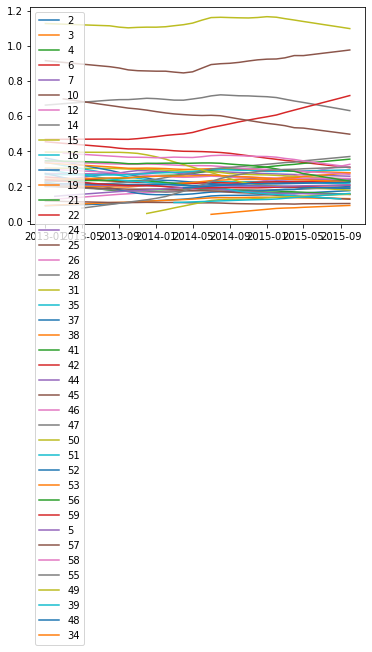

In [6]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_shop = pd.DataFrame()

for shop in all_data.shop_id.unique():

    if shop in closed_shops:
        continue

    sales = (all_data[all_data.shop_id==shop]
             .groupby(["date_block_num"])
             .agg({'total_monthly_shop_sales': lambda x: np.NA if x.empty else x.iloc[0]})
             .reset_index())

    sales = pd.merge(sales[["total_monthly_shop_sales","date_block_num"]], timeline, how='left', on=['date_block_num'])

    sales = sales[sales.date_block_num<34] # month 34 does not have anything

    ts = pd.Series(sales.total_monthly_shop_sales.values, index=sales["begin_date"])

    decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.plot(trend, label=shop)

    decomposition_shop = pd.concat([decomposition_shop,
                             pd.DataFrame({
                                 'date_block_num':  sales.date_block_num,
                                 'n_days':          sales.n_days,
                                 'shop_id':         [shop]*len(ts),
                                 'shop_trend':      trend.values,
                                 'shop_seasonal':   seasonal.values,
                                 'shop_forecast':   trend.values + seasonal.values
                             })])

plt.legend(loc='best')

#all_data[all_data.shop_id.isin(strange_shops)]

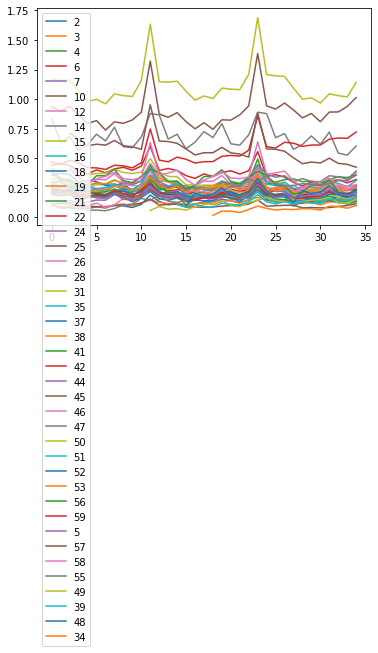

In [7]:
# extrapolate one point ahead basing on 3 points behind (note, all coordinates are relative):
extrapolate = lambda x: np.poly1d( np.polyfit([1,2,3], [x.iloc[-3],x.iloc[-2],x.iloc[-1]], 1) )(4)
#extrapolate.__name__ = "shop_trend"

trend_34 = decomposition_shop.groupby(["shop_id"]).agg({"shop_trend": extrapolate})
trend_34.columns = ["shop_trend"]
trend_34.reset_index()

seasonal_22 = decomposition_shop[decomposition_shop.date_block_num==(34-12)][['shop_id','shop_seasonal']]

forecast_34 = pd.merge(trend_34, seasonal_22, how='inner', on=['shop_id'])
forecast_34['date_block_num'] = 34
forecast_34['n_days'] = 30
forecast_34['shop_forecast'] = forecast_34['shop_trend'] + forecast_34['shop_seasonal']

decomposition_shop = pd.concat([decomposition_shop, forecast_34], sort=True, ignore_index=True)

for shop in decomposition_shop.shop_id.unique():
    plt.plot(decomposition_shop[decomposition_shop.shop_id == shop].date_block_num.values,
             decomposition_shop[decomposition_shop.shop_id == shop].shop_forecast.values,
             label=shop)

plt.legend(loc='best')

In [8]:
train33_open = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)
train33_open = pd.merge(train33_open, decomposition_shop, how='left', on=['date_block_num','shop_id'])

# shop 51 is a special case as it is one point short
train33_open = train33_open[(train33_open.shop_id!=51)|(train33_open.date_block_num<33)]

predictors2 = predictors + ['shop_forecast', 'shop_trend', 'shop_seasonal', 'n_days']

# if you use date_block_num, it should not be categorical when forecasting
train33_open['date_block_num'] = train33_open['date_block_num'].astype(np.float32)

In [10]:
%%time
from sklearn.ensemble import RandomForestRegressor
X_train33_open = train33_open[train33_open.date_block_num <  33][predictors2]
X_valid33_open = train33_open[train33_open.date_block_num == 33][predictors2]
y_train33_open = train33_open[train33_open.date_block_num <  33].target
y_valid33_open = train33_open[train33_open.date_block_num == 33].target

extended_model33_open = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6)
extended_model33_open.fit(X_train33_open, y_train33_open)

CPU times: user 57min 30s, sys: 30.5 s, total: 58min 1s
Wall time: 15min 3s


In [12]:
from sklearn.metrics import mean_squared_error
ypred = extended_model33_open.predict(X_valid33_open)
rmse = np.sqrt(mean_squared_error(y_valid33_open, ypred))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred)))

RMSE good: 0.823223
Average good: 0.2995288133130269


In [13]:
%%time
predictors3 = predictors2[1:]
X_train33_open_nd = train33_open[train33_open.date_block_num <  33][predictors3]
X_valid33_open_nd = train33_open[train33_open.date_block_num == 33][predictors3]
y_train33_open_nd = train33_open[train33_open.date_block_num <  33].target
y_valid33_open_nd = train33_open[train33_open.date_block_num == 33].target

extended_model33_open_nodate = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6)
extended_model33_open_nodate.fit(X_train33_open_nd, y_train33_open_nd)

CPU times: user 58min 17s, sys: 31.2 s, total: 58min 49s
Wall time: 15min 18s


In [16]:
ypred = extended_model33_open_nodate.predict(X_valid33_open_nd)
rmse = np.sqrt(mean_squared_error(y_valid33_open_nd, ypred))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred)))

RMSE good: 0.810270
Average good: 0.28546340562241757


In [17]:
del extended_model33_open_nodate
del extended_model33_open
import gc
gc.collect()

121

In [18]:
%%time
from sklearn.ensemble import RandomForestRegressor
full_model = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6)
full_model.fit(train33_open[predictors2], train33_open.target)

CPU times: user 1h 1min 14s, sys: 28.3 s, total: 1h 1min 42s
Wall time: 15min 59s


In [19]:
from sklearn.ensemble import RandomForestRegressor
full_model_nd = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6)
full_model_nd.fit(train33_open[predictors3], train33_open.target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [36]:
# combine
month_34 = all_data[(all_data.date_block_num == 34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)
ds = decomposition_shop[decomposition_shop.date_block_num == 34]
month_34 = pd.merge(month_34, ds, how='left', on=['date_block_num','shop_id'])

# shop #51 and #36 are special cases:
month_34 = month_34[(month_34.shop_id!=51)&(month_34.shop_id!=36)]

month_34['item_cnt_month'] = full_model.predict(month_34[predictors2]) # _nd, 3
test = pd.merge(test_df, month_34, how='left', on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"] #.round().astype("int64") do not round up, you are screwing RSS

test[test.item_cnt_month>20] = 20
test.to_csv("plus_seasonal_predictors33_floatingdate.csv") # _nd

In [15]:
# leaderboard probing: let's find out if shop #36 has non zero flat sales:
item_id = test_df.item_id.unique()

month_34 = pd.concat([month_34, pd.DataFrame({'date_block_num': [34]*len(item_id),
                                              'shop_id':        [36]*len(item_id),
                                              'item_cnt_month': [1] *len(item_id),
                                              'item_id':        item_id})])

test = pd.merge(test_df, month_34, how='left', on=["shop_id","item_id"]).fillna(0)

print(test[test.shop_id==36][['shop_id', 'item_cnt_month']].head())

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"] #.round().astype("int64") do not round up, you are screwing RSS

test[test.item_cnt_month>20] = 20
#test.to_csv("plus_seasonal_predictors33_shop36eq1.csv")

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


        shop_id  item_cnt_month
163200       36             1.0
163201       36             1.0
163202       36             1.0
163203       36             1.0
163204       36             1.0


In [ ]:
# extended_model33_open (plus_seasonal_predictors33_undertrained.csv) is achieving 0.90799 public score
#  as opposed to full_model with its 0.91383

In [ ]:
# public score changes from 0.91383 to 0.92127 - a clear 1% loss due to shop #36 selling one item of every type,
# it is better to apply an average profile per item to the shop or, in other words, construct mean encoding over items

In [ ]:
# it doesn't metter if date_block_num is turned to floating point, the public score stays 0.91550 (_floatingdate)
#  while dropping it all together makes things worse: 0.92712

In [38]:
# leaderboard probing: let's find out if shop #36 has non zero mean-profiled sales:
item_id = test_df.item_id.unique()

############################################################################
# combine
month_34 = all_data[(all_data.date_block_num == 34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)
ds = decomposition_shop[decomposition_shop.date_block_num == 34]
month_34 = pd.merge(month_34, ds, how='left', on=['date_block_num','shop_id'])

# shop #51 and #36 are special cases:
month_34 = month_34[(month_34.shop_id!=51)&(month_34.shop_id!=36)]

month_34['item_cnt_month'] = full_model.predict(month_34[predictors2])
############################################################################

aggregated_sales = all_data.groupby(["date_block_num", "item_id"]).agg({'target': np.mean}).reset_index()
aggregated_sales['shop_id'] = 36
q = aggregated_sales[aggregated_sales.date_block_num == 33][['item_id', 'shop_id', 'target']]
q.columns = ['item_id', 'shop_id', 'item_cnt_month']

month_34 = pd.concat([month_34[['item_id', 'shop_id', 'item_cnt_month']], q])

test = pd.merge(test_df, month_34, how='left', on=["shop_id","item_id"]).fillna(0)

print(test[test.shop_id==36][['shop_id', 'item_cnt_month']].head())

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"] #.round().astype("int64") do not round up, you are screwing RSS

test[test.item_cnt_month>20] = 20
test.to_csv("plus_seasonal_predictors33_shop36eqMean.csv")

        shop_id  item_cnt_month
163200       36        0.568182
163201       36        0.000000
163202       36        0.954545
163203       36        0.636364
163204       36        0.000000


In [ ]:
#public score of 0.91148 suggest you gain nothing by micro-forecasting shop #36

In [5]:
%%time
train33_open = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)

from sklearn.ensemble import RandomForestRegressor
full_model_ref = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
full_model_ref.fit(train33_open[predictors], train33_open.target)

CPU times: user 1h 2min 21s, sys: 31.6 s, total: 1h 2min 53s
Wall time: 16min 33s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [6]:
# leaderboard probing: let's find out if shop #36 has non zero mean-profiled sales:
item_id = test_df.item_id.unique()

############################################################################
# combine
month_34 = all_data[(all_data.date_block_num == 34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)
# shop #51 and #36 are special cases:
month_34 = month_34[(month_34.shop_id!=51)&(month_34.shop_id!=36)]

month_34['item_cnt_month'] = full_model_ref.predict(month_34[predictors])
############################################################################

test = pd.merge(test_df, month_34, how='left', on=["shop_id","item_id"]).fillna(0)

print(test[test.shop_id==36][['shop_id', 'item_cnt_month']].head())

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"] #.round().astype("int64") do not round up, you are screwing RSS

test[test.item_cnt_month>20] = 20
test.to_csv("full_model_ref33_123.csv")

        shop_id  item_cnt_month
163200       36             0.0
163201       36             0.0
163202       36             0.0
163203       36             0.0
163204       36             0.0


In [ ]:
#public score of 0.99 confirms that including date #33 (in comparison with macro4) makes things worse